In [1]:
import os
import sys
import csv
import pandas as pd
import matplotlib as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


In [2]:
from keras.layers import Reshape, Embedding, Conv1D, MaxPooling1D,GlobalMaxPooling1D, Flatten, Dense,LSTM, GRU,Bidirectional,Dropout, Conv3D
from tensorflow.keras import Input
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
import keras.backend as K
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm



In [3]:
from gensim.models import Word2Vec, KeyedVectors
from collections import defaultdict

In [4]:
## for bag-of-words
from sklearn import feature_extraction, model_selection, manifold, preprocessing, feature_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

 ## Data Acquisition




In [5]:
def downloadDataset():
  if  not os.path.isfile('./drive/MyDrive/QS-OCR-small.tar.gz'):
    print("Downloading... ")
    ! wget https://github.com/QuickSign/ocrized-text-dataset/releases/download/v1.0/QS-OCR-small.tar.gz -P ./drive/MyDrive/
    !mkdir ./drive/MyDrive/dataset
    !tar -xf QS-OCR-small.tar.gz -C ./drive/MyDrive/dataset
  else: 
    print("Dataset has already been downloaded. ")

In [6]:
def createSingleDataset(filename):
  # join all the file content into a single csv file
  if not os.path.isfile(filename):
    print("joining..")
    path = "./drive/MyDrive/dataset"
    file_dataset = open(filename, mode='w')
    file_writer = csv.writer(file_dataset, delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    #walk trough the directory to get all the files' content
    for dirpath, dirs, filenames in os.walk(path):
      for filename in filenames:
        f = open(dirpath +"/"+filename, "r")
        getfilebody = f.read()
        file_writer.writerow([filename, getfilebody,  dirpath.replace("./drive/MyDrive/dataset/", "") ] )
        f.close()
  else:
      print("Dataset files have already been joined. ")

In [7]:
def get_data(): 
  downloadDataset()
  createSingleDataset('./drive/MyDrive/dataset.csv')
  df = pd.read_csv("./drive/MyDrive/dataset.csv", sep='|', delimiter=None, names = ["filename","content", "label"] )
  return df

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

##Pre-Processing
Data cleaning:
  >* filling in missing values,
  >*  smoothing noisy data,
  >* identifying or removing outliers,
  >* resolving inconsistencies,
  >* duplicate samples
  >* NLP pipeline = data normalizzation for text
  >>* Tokenization
  >>* punctuation removal
  >>* stop words removal
  >>* noise removal: Remove HTML tags, remove extra whitespaces, 
  >>* normalization: typo correction,  converting all characters to lowercase, number, date, symbol textualization, Expand contractions, remove_accented_chars
  >>* lemmatization o steaming 


In [9]:
def remove_tags(string):
    result = re.sub('<.*?>',' ',string)
    result = re.sub(r'\b\w{1,3}\b', '', result) #remove words with legth < 3 chars
    return result

def clean_text(text):
  for t in nlp.tokenizer(text):
    if ((not t.is_stop) and ( not t.is_punct) and (not t.is_currency) and (not t.is_digit) and (not t.is_space) and (t.is_alpha) ):
      return t.lemma_.lower().join(t.pos_)

def execute_nlp(df):
  nlp = spacy.load('en')  
  #speech tag removed because it's too slow
  df.insert(1, 'cleaned_text', df['content_without_tags'].apply(lambda x: [t.lemma_.lower() for t in nlp.tokenizer(x) if ((not t.is_stop) and ( not t.is_punct) and (not t.is_currency) and (not t.is_digit) and (not t.is_space) and (t.is_alpha) ) ]))
  return df



In [10]:

!pip install langid
import spacy 
import en_core_web_sm
import langid
import re as re

def pre_processing(df):
  # nan removing
  df = df.dropna()

  #label encoding
  categories = pd.unique(df["label"])
  labelencoder = LabelEncoder()
  df['y'] = labelencoder.fit_transform(df['label'])
  
  #nlp pipeline

  df['content']=df['content'].apply(str)
  df.insert(1, 'content_without_tags', df["content"].apply(lambda cw : remove_tags(cw)))  #removing HTML tags
  df = execute_nlp(df)        

  #remove unuseful column
  df = df.drop("content_without_tags", axis = 1)
  df = df.drop("filename", axis = 1)
  
  return df , categories


     |████████████████████████████████| 1.9MB 6.0MB/s 
  Created wheel for langid: filename=langid-1.1.6-cp36-none-any.whl size=1941191 sha256=9cf73c10bb7457650438854d1d4004dc6594fe6db0b42cc2825166b94c9b62e9
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid


## Visualization and Dataset Analysis

In [11]:
!pip install wordcloud
!pip install pillow
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

def word_cloud(df):
   
  comment_words = '' 
  
  # iterate through the csv file 
  for val in df.cleaned_text: 
        
      # typecaste each val to string 
      val = str(val) 
    
      # split the value 
      tokens = val.split() 
        
      # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
        
      comment_words += " ".join(tokens)+" "
    
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  min_font_size = 10).generate(comment_words) 
      
  return wordcloud
  


In [12]:
def plot_wordcloud(wordcloud):
  fig = plt.pyplot.figure(figsize=(32,32))
  pos=0
  for i in categories:
    row = 1  
    if pos > 4 :
      row = 2  
    fig.add_subplot(row, 5, (pos % 5)+1)

    plt.pyplot.imshow(wordcloud[i]) 
    plt.pyplot.axis("off") 
    plt.pyplot.title( wordcloud.index[pos], fontsize=22)

    plt.pyplot.tight_layout(pad = 0) 
    pos += 1
      
  plt.pyplot.show()  

In [13]:
"""df = get_data()
df, categories = pre_processing(df)
wordcloud = df.groupby('label').apply(lambda x: word_cloud(x))
plot_wordcloud(wordcloud) """

"df = get_data()\ndf, categories = pre_processing(df)\nwordcloud = df.groupby('label').apply(lambda x: word_cloud(x))\nplot_wordcloud(wordcloud) "

### Utils

In [14]:
## split dataset
def split_dataset(X, y):
  #X = df.iloc[:, 0 ]
  # y = df.iloc[:, 4 ]
  X_train, X_test, y_train, y_test= model_selection.train_test_split(X, y, test_size=0.3, random_state = 42)
  X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

  #y_test = y_test.values.reshape((1045,1))
  return X_train, X_test, y_train, y_test, X_val, y_val



In [15]:
def get_most_frequent_word(number_of_word_to_get):
  sentences = [row.split() for row in df['cleaned_text']] #tokenize sentence

  #create dictionary word_freq(word, number_of_occurence)
  word_freq = defaultdict(int)
  for sent in sentences:
      for i in sent:
        # print(sent)
          #print(i)
          word_freq[i] += 1
          
  print("top 10 most frequent words:", sorted(word_freq, key=word_freq.get, reverse=True)[:number_of_word_to_get])
  #word_freq



In [16]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [17]:
def getPerformanceMetricsBERT(model, X_test, y_test, modelName):
  print(modelName, "metrics: ")
  from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,roc_curve,auc,precision_recall_curve
  y_pred = model.predict(X_test)
  #predicted_prob = model.predict_proba(X_test)
  print('accuracy %s' % accuracy_score(y_pred.round(), y_test))
  print(classification_report(y_test, y_pred.round(), target_names=categories))
   ## Plot confusion matrix
  #print("confusion Matrix", modelName)
  cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  fig, ax = plt.pyplot.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=categories, 
        yticklabels=categories, title="Confusion matrix "+modelName)
  plt.pyplot.yticks(rotation=0)
  plt.pyplot.show()

In [18]:
def plot_accuracy_loss(history): 
  plt.pyplot.subplot(211)
  plt.pyplot.plot(history.history['get_f1'])
  plt.pyplot.title('model f1_score')
  plt.pyplot.ylabel('f1_score')
  plt.pyplot.plot(history.history['val_get_f1'])
  plt.pyplot.xlabel('epoch')
  plt.pyplot.legend(['train', 'val'], loc='upper left')
  plt.pyplot.subplot(212)
  plt.pyplot.plot(history.history['loss'])
  plt.pyplot.title('val loss')
  plt.pyplot.ylabel('loss')
  plt.pyplot.plot(history.history['val_loss'])
  plt.pyplot.xlabel('epoch')
  plt.pyplot.legend(['train', 'val'], loc='upper left')
  plt.pyplot.show()

## Baseline Model 

In [19]:

def multinomialNBmodel():
  nb = Pipeline([('vectorizer', feature_extraction.text.CountVectorizer()),
                ('tfidf', feature_extraction.text.TfidfTransformer()),
               ('clf', MultinomialNB()),])
  return nb
def SVMmodel():
  svm = Pipeline([('vectorizer', feature_extraction.text.CountVectorizer()),
                ('tfidf', feature_extraction.text.TfidfTransformer()),
               ('clf',  SGDClassifier(penalty='l2', alpha=1e-3, random_state=42)),])
  return svm

def getPerformanceMetrics(model, X_test, y_test, modelName):
  from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,roc_curve,auc,precision_recall_curve
  y_pred = model.predict(X_test)
  #predicted_prob = model.predict_proba(X_test)
  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred, target_names=categories))
   ## Plot confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.pyplot.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=categories, 
        yticklabels=categories, title="Confusion matrix"+ modelName)
  plt.pyplot.yticks(rotation=0)
#  fig, ax = plt.pyplot.subplots(nrows=1, ncols=2)
  

#NOTE: with MultinomialNB and tfidf there are label that are not predicted 

In [20]:
def compute_baseline(X_train, X_test, y_train, y_test, X_val, y_val):   #model = multinomialNBmodel()
  #X_train, X_test, y_train, y_test, X_val, y_val = split_dataset(df.iloc[:, 0 ],df.iloc[:, 4])  #cleaned text and string label
  model = SVMmodel()
  model.fit(X_train, y_train)
  getPerformanceMetrics(model, X_test, y_test, "SVMmodel")


## Modeling - Word Embeddings

####Create Customized Word Embedding

In [21]:
def create_custom_word_embedding(df):
    sentences = [row.split() for row in df['cleaned_text']] #tokenize sentence
    w2v_model = Word2Vec(min_count=100, #min_count: minimum amount of time a word appear in word2vec training corpus  
                        window=5,  # context window +- center word
                        size=100,  # dimensions of word embeddings, also refer to size of hidden layer
                        workers=4,
                        sg =1 )#1= skip-gram, 0 = cbow
                        
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
    w2v_model.init_sims(replace=True)
    print("vocab length",len(w2v_model.wv.vocab))
    return  w2v_model


In [22]:
#testing word embedding
#Find the most similar words for "smoke"
def test_word_embedding(w2v_model, word):
  print(w2v_model.wv.most_similar(positive=[word]))



In [23]:
from sklearn.manifold import TSNE
def visualize_word2vec_model(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.pyplot.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.pyplot.scatter(x[i],y[i])
        plt.pyplot.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.pyplot.show()


In [24]:
def save_pretrained_word_embedding(filename, isBin, w2v_model):
  w2v_model.wv.save_word2vec_format(filename, binary = isBin)


#### Modeling Using Custom Word Embedding

In [25]:
def inits_params_word_embedding(vocab_len, max_sequence_length, embedding_dim ):
  MAX_NB_WORDS = vocab_len
  MAX_SEQUENCE_LENGTH = max_sequence_length # 800
  #VALIDATION_SPLIT = val_split  #0.2
  EMBEDDING_DIM = embedding_dim #300 #has to be between 100 and 300
  
  return MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM


In [26]:
"""def data_preparation(df, MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, VALIDATION_SPLIT, EMBEDDING_DIM):
  #convert data into vector to fit word embedding:
    # it means vectorize a text corpus, by turning each text into either a sequence of integers 
  tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
  tokenizer.fit_on_texts(df["cleaned_text"])   #In the case where texts contains lists, we assume each entry of the lists to be a token.
  sequences = tokenizer.texts_to_sequences(df["cleaned_text"])  #turn each list into a "sequence": is a list of integer word indices. 
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH) #X

  labels = to_categorical(np.asarray(df["y"])) #y
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)

  # split the data into a training set and a validation set
  
  X_train, X_test, y_train, y_test, x_val, y_val = split_dataset(data, labels)
    
  return word_index, X_train, X_test, y_train, y_test, x_val, y_val, y_test"""


'def data_preparation(df, MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, VALIDATION_SPLIT, EMBEDDING_DIM):\n  #convert data into vector to fit word embedding:\n    # it means vectorize a text corpus, by turning each text into either a sequence of integers \n  tokenizer = Tokenizer(num_words = MAX_NB_WORDS)\n  tokenizer.fit_on_texts(df["cleaned_text"])   #In the case where texts contains lists, we assume each entry of the lists to be a token.\n  sequences = tokenizer.texts_to_sequences(df["cleaned_text"])  #turn each list into a "sequence": is a list of integer word indices. \n  word_index = tokenizer.word_index\n  print(\'Found %s unique tokens.\' % len(word_index))\n\n  data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH) #X\n\n  labels = to_categorical(np.asarray(df["y"])) #y\n  print(\'Shape of data tensor:\', data.shape)\n  print(\'Shape of label tensor:\', labels.shape)\n\n  # split the data into a training set and a validation set\n  \n  X_train, X_test, y_train, y_test, x_val, y_v

In [27]:
def data_preparation(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val, y_train, y_test, y_val):
  #convert data into vector to fit word embedding:
    # it means vectorize a text corpus, by turning each text into either a sequence of integers 
  #print(X_train.head(5))
  tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
  tokenizer.fit_on_texts(X_train)   #In the case where texts contains lists, we assume each entry of the lists to be a token.
  tokenizer.fit_on_texts(X_test)
  tokenizer.fit_on_texts(X_val)

  X_train_sequences = tokenizer.texts_to_sequences(X_train)  #turn each list into a "sequence": is a list of integer word indices. 
  X_test_sequences = tokenizer.texts_to_sequences(X_test) 
  X_val_sequences = tokenizer.texts_to_sequences(X_val) 
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #print(X_train_sequences)

  X_train_sequences = pad_sequences(X_train_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  X_test_sequences = pad_sequences(X_test_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  X_val_sequences = pad_sequences(X_val_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X

  y_train = to_categorical(np.asarray(y_train)) #y
  y_test = to_categorical(np.asarray(y_test)) #y
  y_val = to_categorical(np.asarray(y_val)) #y
  
  return word_index, X_train_sequences, X_test_sequences, X_val_sequences, y_train, y_test, y_val, tokenizer

In [28]:
def load_word_embedding(filename):
  #extracting vocabs from 'word_embedding.txt'
  embeddings_index = {}
  f = open(os.path.join("", filename),encoding='utf-8' )
  for line in tqdm(f):
      values = line.rstrip().rsplit(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('Found %s word vectors.' % len(embeddings_index))

  return embeddings_index

In [29]:
#create embedding matrix that join pretrained word embedding with the dataset's vocabulary
def create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM):
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix


In [30]:
def inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
  print("embedding_layer")
  embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
  return embedding_layer

In [31]:
def run_model(model,  x_train, y_train,  x_val, y_val, modelName):
  model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=[get_f1, "accuracy"])
  es_callback = EarlyStopping(monitor='val_loss', patience=3)
  #history = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
  model.summary()
  # happy learning!
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=20, batch_size=64,  callbacks=[es_callback], shuffle=False)
  model.save(modelName)
  
  plot_accuracy_loss(history)

  print("history", history)
  hist_df = pd.DataFrame(history.history) 

  hist_csv_file = './drive/MyDrive/history/history' + modelName.replace("./drive/MyDrive/", "") + '.csv'   
  with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
  return model

In [32]:

def define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH):

  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  x = Conv1D(128, 5, activation='relu')(embedded_sequences)
  x = MaxPooling1D(5)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D(5)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D()(x)  # global max pooling
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  preds = Dense(10, activation='softmax')(x)
  
  model = keras.Model(sequence_input, preds)

  return model


In [33]:
def define_LSTM_model(embedding_layer, MAX_SEQUENCE_LENGTH,  word_index): 
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  modelLSTM = keras.Sequential()
  embedded_sequences = embedding_layer(sequence_input)
  modelLSTM.add(embedding_layer)
  modelLSTM.add(Bidirectional(LSTM(units=32, dropout=0.3,recurrent_dropout=0.2)))
  modelLSTM.add(Dense(32,activation='relu'))
  modelLSTM.add(Dropout(0.3))
  modelLSTM.add(Dense(10,activation="softmax"))
  return modelLSTM


In [34]:
def training_over_custom_word_embedding(df, X_train, X_test, y_train, y_test, X_val, y_val):
  w2v_model = create_custom_word_embedding(df)  
  visualize_word2vec_model(w2v_model)
  save_pretrained_word_embedding("word_embedding.txt", False, w2v_model)

  #get dataset info
  max_words_for_sentence = df["number_of_words"].max()
  median_words_for_sentence = df["number_of_words"].median()
  vocab_len = len(w2v_model.wv.vocab)
  print("vocab length: ",len(w2v_model.wv.vocab), "max", max_words_for_sentence)



  MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = inits_params_word_embedding(len(w2v_model.wv.vocab), max_words_for_sentence, 100 )
  #word_index, x_train, x_test, y_train,y_val, x_val, y_val, y_test = data_preparation(df,MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, VALIDATION_SPLIT, EMBEDDING_DIM)
  word_index, x_train, x_test, x_val, y_train, y_test, y_val, tokenizer = data_preparation(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val, y_train, y_test, y_val)


 # X_train, X_test, y_train, y_test, x_val, y_val

  embeddings_index = load_word_embedding('word_embedding.txt')
  embedding_matrix =create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM)
  if not os.path.isdir("./drive/MyDrive/CNN_model_custom_WEskipgram") or not os.path.isdir("./drive/MyDrive/LSTM_model_custom_WEskipgram") :
    print("models are training...")
    embedding_layer = inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM )
    CNN_model_custom_we = define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH) 
    CNN_model_custom_we = run_model(CNN_model_custom_we, x_train, y_train,  x_val, y_val, "./drive/MyDrive/CNN_model_custom_WEskipgram")
    #getPerformanceMetricsBERT(CNN_model_custom_we, x_test, y_test )

    LSTM_model_custom_we = define_LSTM_model(embedding_layer, MAX_SEQUENCE_LENGTH, word_index)
    LSTM_model_custom_we.summary()
    LSTM_model_custom_we = run_model(LSTM_model_custom_we,  x_train, y_train,  x_val, y_val, "./drive/MyDrive/LSTM_model_custom_WEskipgram")

    #getPerformanceMetricsBERT(modelLstm, x_test, y_test )
  else:
    #load trained models
    print("models already trained, loading...")
    LSTM_model_custom_we = tf.keras.models.load_model('./drive/MyDrive/LSTM_model_custom_WEskipgram',  custom_objects={'get_f1': get_f1})
    CNN_model_custom_we = tf.keras.models.load_model('./drive/MyDrive/CNN_model_custom_WEskipgram',  custom_objects={'get_f1': get_f1}) 
  
  return LSTM_model_custom_we, CNN_model_custom_we

#### Modeling Using Glove Pre-trained Word Embedding

In [35]:
import requests, zipfile, io
def glove_download(): 
  if  not os.path.isfile('./drive/MyDrive/glove.840B.300d.txt/glove.840B.300d.txt'):
    print("Downloading... ")
    zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./drive/MyDrive/glove.840B.300d.txt")
  else: 
    print("glove has already been downloaded")




In [36]:
def training_over_glove_word_embedding(df, X_train, X_test, y_train, y_test, X_val, y_val):
  glove_download()
  embeddings_index = load_word_embedding('./drive/MyDrive/glove.840B.300d.txt/glove.840B.300d.txt')
  #TODO: define MAX_NB_WORDS correctly
  max_words_for_sentence = df["number_of_words"].max()
  median_words_for_sentence = df["number_of_words"].median()

  MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = inits_params_word_embedding(len(embeddings_index), max_words_for_sentence, 300 )
 
  word_index, x_train, x_test, x_val, y_train, y_test, y_val, tokenizer = data_preparation(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, X_train, X_test, X_val, y_train, y_test, y_val)

  embedding_matrix =create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM)

  
  if not os.path.isdir("./drive/MyDrive/CNN_model_glove_WE1") or not os.path.isdir("./drive/MyDrive/LSTM_model_glove_WE1") :
    print("models are training...")
    embedding_layer = inits_params_embedding_layer(embedding_matrix, word_index, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM )
    CNN_model_glove_we = define_CNN_model(embedding_layer, MAX_SEQUENCE_LENGTH) 
    CNN_model_glove_we = run_model(CNN_model_glove_we, x_train, y_train,  x_val, y_val, "./drive/MyDrive/CNN_model_glove_WE1")
    getPerformanceMetricsBERT(CNN_model_glove_we, x_test, y_test, './drive/MyDrive/CNN_model_glove_WE1' )

    LSTM_model_glove_we = define_LSTM_model(embedding_layer, MAX_SEQUENCE_LENGTH, word_index)
    LSTM_model_glove_we.summary()
    LSTM_model_glove_we = run_model(LSTM_model_glove_we,  x_train, y_train,  x_val, y_val, "./drive/MyDrive/LSTM_model_glove_WE1")
    getPerformanceMetricsBERT(LSTM_model_glove_we, x_test, y_test, './drive/MyDrive/LSTM_model_glove_WE1' )
    
  else:
    #load trained models
    print("models already trained, loading...")
    LSTM_model_glove_we = tf.keras.models.load_model('./drive/MyDrive/LSTM_model_glove_WE1',  custom_objects={'get_f1': get_f1})
    getPerformanceMetricsBERT(LSTM_model_glove_we, x_test, y_test, './drive/MyDrive/LSTM_model_glove_WE1' )

    CNN_model_glove_we = tf.keras.models.load_model('./drive/MyDrive/CNN_model_glove_WE1',  custom_objects={'get_f1': get_f1}) 
    getPerformanceMetricsBERT(CNN_model_glove_we, x_test, y_test, './drive/MyDrive/CNN_model_glove_WE1' )

  return LSTM_model_glove_we, CNN_model_glove_we, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer

#### Bert Tensorflow 

In [37]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.9MB/s 


In [38]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [39]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [40]:
### Add tokens to the data make it BERT compatible
def bert_encode(test_df, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    #for text in texts:
    for i in tqdm(range(len(test_df))):
        text = tokenizer.tokenize(test_df.iloc[i])
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    print(clf_output.shape)
    #model ok #f1 = 82 % 
    flat_layer = Flatten()(clf_output)
    dropout= Dropout(0.2)(flat_layer)

    out = Dense(10, activation='softmax')(dropout)
   
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='categorical_crossentropy', metrics=['accuracy', get_f1])

    return model



In [41]:
def training_with_bert(X_train, X_test, y_train, y_test, X_val, y_val, modelName):
  
  y_train = to_categorical(np.asarray(y_train)) #y 
  y_test = to_categorical(np.asarray(y_test)) #y
  y_val = to_categorical(np.asarray(y_val))

  module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
  #module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

  bert_layer = hub.KerasLayer(module_url, trainable=True)

  vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
  do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

  tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
  train_input = bert_encode(X_train, tokenizer, max_len=128)
  test_input = bert_encode(X_test, tokenizer, max_len=128)
  val_input = bert_encode(X_val, tokenizer,  max_len=128)

  if not os.path.isdir(modelName) :
    print("models are training...")

    bert = build_model(bert_layer, max_len=128)
    bert.summary()
    es_callback = EarlyStopping(monitor='val_loss', patience=3)
    history = bert.fit(
          train_input, y_train,
          validation_data=(val_input, y_val), 
          epochs=25,
          batch_size=16,
          callbacks=[es_callback]
    )
    bert.save(modelName)
    print("history", history)
    hist_df = pd.DataFrame(history.history) 

    hist_csv_file = './drive/MyDrive/history/history' + modelName.replace("./drive/MyDrive/", "") + '.csv'   
    with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)

    plot_accuracy_loss(history)
    getPerformanceMetricsBERT(bert, test_input, y_test,modelName)
  else: 
    #load trained models
    print("models already trained, loading...")
    bert = tf.keras.models.load_model(modelName,  custom_objects={'get_f1': get_f1})
    getPerformanceMetricsBERT(bert, test_input, y_test, modelName )
  return bert


Dataset has already been downloaded. 
Dataset files have already been joined. 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


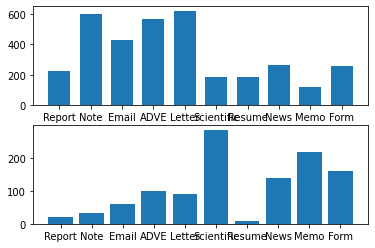

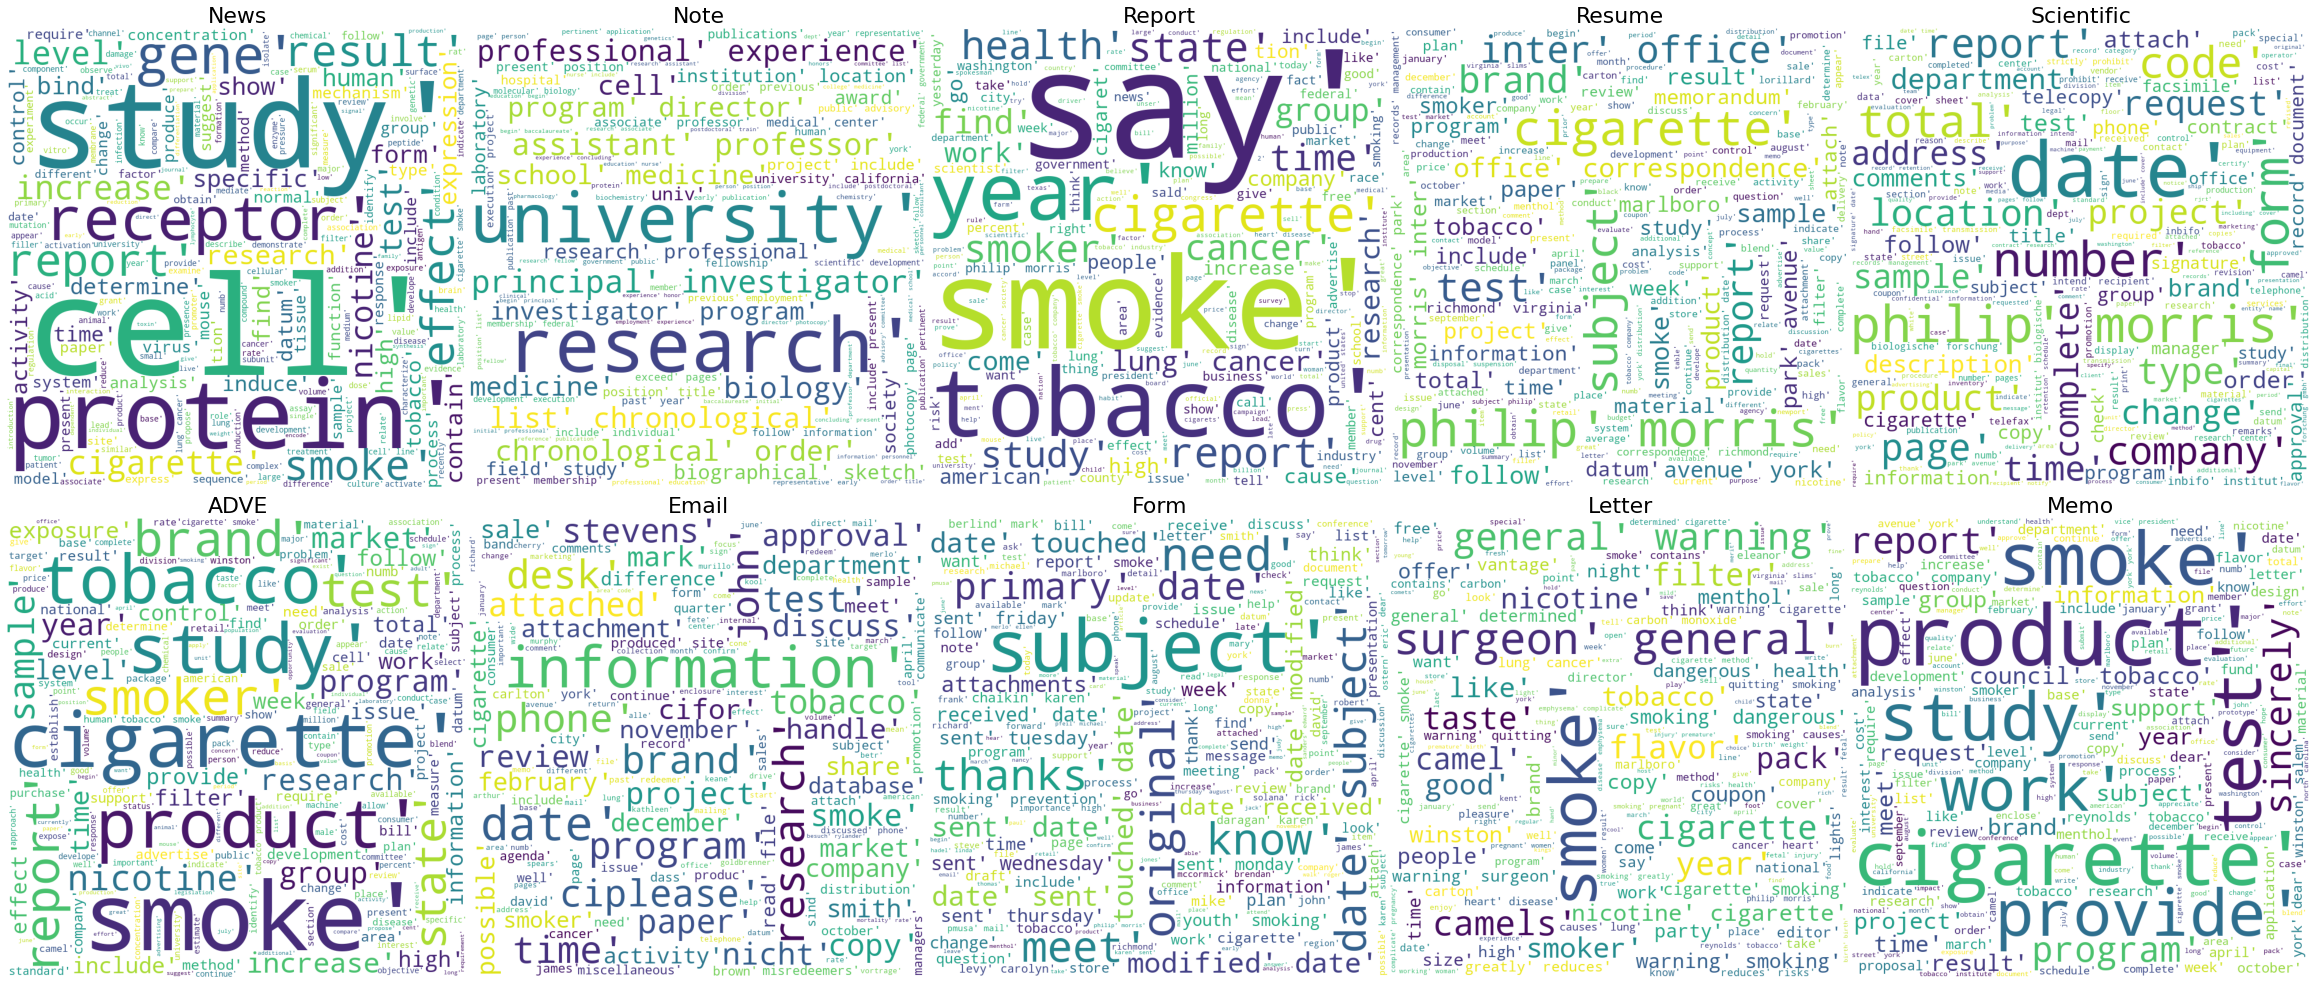

accuracy 0.7420596727622714
              precision    recall  f1-score   support

      Report       0.81      0.59      0.68        73
        Note       0.86      0.97      0.91       184
       Email       0.78      0.83      0.81       132
        ADVE       0.74      0.75      0.74       169
      Letter       0.68      0.85      0.75       183
  Scientific       0.58      0.84      0.68        49
      Resume       0.73      0.49      0.59        65
        News       0.78      0.19      0.31        93
        Memo       0.90      1.00      0.95        27
        Form       0.60      0.62      0.61        64

    accuracy                           0.74      1039
   macro avg       0.74      0.71      0.70      1039
weighted avg       0.75      0.74      0.72      1039



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # Remove the CWD from sys.path while we load stuff.


vocab length 650


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


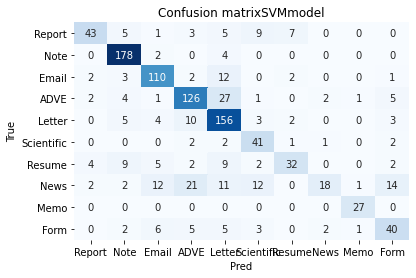

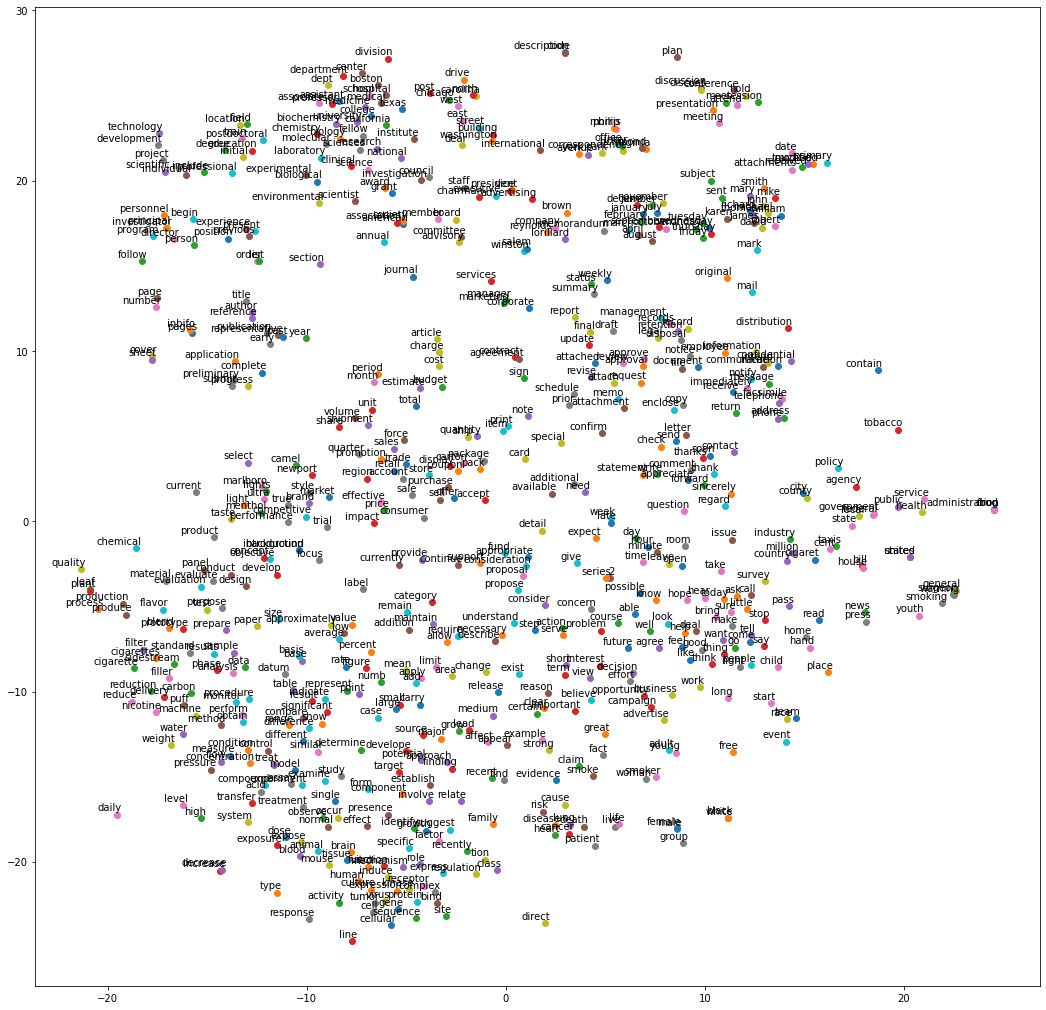

vocab length:  650 max 730


651it [00:00, 31027.61it/s]

Found 51756 unique tokens.
X_train_sequences (1938, 730) y_train (1938, 10)
X_test_sequences (1039, 730) y_test (1039, 10)
X_val_sequences (485, 730) y_val (485, 10)
Found 651 word vectors.
models already trained, loading...


0it [00:00, ?it/s]

glove has already been downloaded


2196017it [03:27, 10598.29it/s]


Found 2196016 word vectors.
X_train_sequences (1938,) y_train 2502    4
2792    4
2581    4
332     6
1800    3
       ..
461     6
3122    2
418     6
2673    4
1437    3
Name: y, Length: 1938, dtype: int64
X_test_sequences (1039,) y_test 2631    4
423     6
1917    9
2539    4
3274    2
       ..
1900    9
2678    4
104     7
2599    4
2690    4
Name: y, Length: 1039, dtype: int64
X_val_sequences (485,) y_val 2554    4
2229    8
2187    8
140     7
394     6
       ..
3151    2
2266    5
1483    3
2850    4
3284    2
Name: y, Length: 485, dtype: int64
Found 51756 unique tokens.
X_train_sequences (1938, 730) y_train (1938, 10)
X_test_sequences (1039, 730) y_test (1039, 10)
X_val_sequences (485, 730) y_val (485, 10)
models already trained, loading...
./drive/MyDrive/LSTM_model_glove_WE1 metrics: 
accuracy 0.6371511068334937
              precision    recall  f1-score   support

      Report       0.75      0.64      0.69        73
        Note       0.96      0.94      0.95       184
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


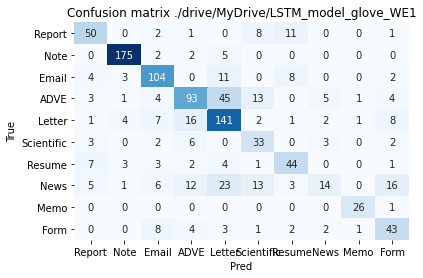

./drive/MyDrive/CNN_model_glove_WE1 metrics: 
accuracy 0.7834456207892204
              precision    recall  f1-score   support

      Report       0.80      0.53      0.64        73
        Note       0.94      0.97      0.95       184
       Email       0.74      0.78      0.76       132
        ADVE       0.85      0.81      0.83       169
      Letter       0.95      0.83      0.88       183
  Scientific       0.78      0.82      0.80        49
      Resume       0.49      0.78      0.60        65
        News       0.75      0.49      0.60        93
        Memo       0.96      0.89      0.92        27
        Form       0.65      0.70      0.68        64

   micro avg       0.81      0.78      0.79      1039
   macro avg       0.79      0.76      0.77      1039
weighted avg       0.82      0.78      0.79      1039
 samples avg       0.78      0.78      0.78      1039



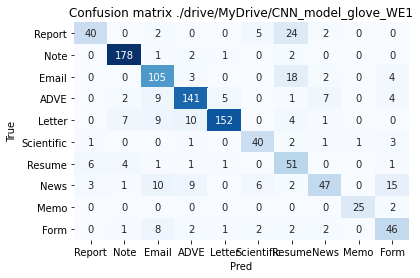

100%|██████████| 485/485 [00:01<00:00, 426.58it/s]


models already trained, loading...
./drive/MyDrive/BERT_model_preProcessing1 metrics: 
accuracy 0.7834456207892204
              precision    recall  f1-score   support

      Report       0.89      0.55      0.68        73
        Note       0.95      0.97      0.96       184
       Email       0.82      0.82      0.82       132
        ADVE       0.83      0.78      0.80       169
      Letter       0.91      0.84      0.87       183
  Scientific       0.78      0.78      0.78        49
      Resume       0.69      0.65      0.67        65
        News       0.70      0.56      0.62        93
        Memo       1.00      1.00      1.00        27
        Form       0.75      0.69      0.72        64

   micro avg       0.85      0.78      0.81      1039
   macro avg       0.83      0.76      0.79      1039
weighted avg       0.84      0.78      0.81      1039
 samples avg       0.78      0.78      0.78      1039



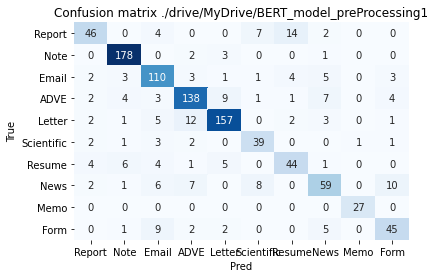

100%|██████████| 485/485 [00:01<00:00, 248.38it/s]


models already trained, loading...
./drive/MyDrive/BERT_model_no_preProcessing metrics: 
accuracy 0.8046198267564967
              precision    recall  f1-score   support

      Report       0.87      0.62      0.72        73
        Note       0.99      0.98      0.99       184
       Email       0.84      0.87      0.86       132
        ADVE       0.87      0.79      0.83       169
      Letter       0.88      0.90      0.89       183
  Scientific       0.76      0.78      0.77        49
      Resume       0.76      0.65      0.70        65
        News       0.75      0.51      0.60        93
        Memo       0.96      0.89      0.92        27
        Form       0.67      0.70      0.69        64

   micro avg       0.86      0.80      0.83      1039
   macro avg       0.83      0.77      0.80      1039
weighted avg       0.86      0.80      0.83      1039
 samples avg       0.80      0.80      0.80      1039



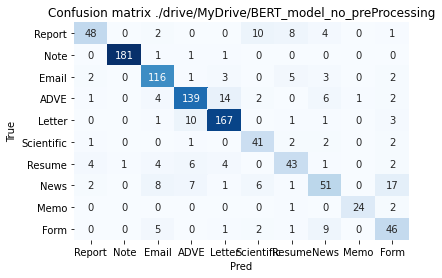

In [42]:
df = get_data()
df , categories= pre_processing(df)

categoryDistribution = df.groupby(["label"])["content"].count()
plt.pyplot.subplot(211)
plt.pyplot.bar(categories, categoryDistribution, width = 0.7, bottom=None, align='center', data=None)
#visualize mean of sentence lenght for each category
df.insert(1, 'number_of_words', df.cleaned_text.apply(lambda x: len(x)))
median_words_for_sentence = df.groupby("label")["number_of_words"].median()
plt.pyplot.subplot(212)
plt.pyplot.bar(categories, median_words_for_sentence, width = 0.8, bottom=None, align='center', data=None)

#df.groupby('label').apply(lambda x: word_cloud(x))
wordcloud = df.groupby('label').apply(lambda x: word_cloud(x))
plot_wordcloud(wordcloud)
#cast cleaned text into string
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ', '.join(map(str, x)))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.replace(",", ""))
X_train, X_test, y_train, y_test, X_val, y_val = split_dataset(df["cleaned_text"], df["y"])

compute_baseline(X_train, X_test, y_train, y_test, X_val, y_val)

LSTM_model_custom_we, CNN_model_custom_we = training_over_custom_word_embedding(df, X_train, X_test, y_train, y_test, X_val, y_val)

LSTM_model_glove_we, CNN_model_glove_we,MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, tokenizer = training_over_glove_word_embedding(df, X_train, X_test, y_train, y_test, X_val, y_val)

bert_preprocess = training_with_bert(X_train, X_test, y_train, y_test, X_val, y_val, "./drive/MyDrive/BERT_model_preProcessing1")

X_train_noPrep, X_test_noPrep, y_train_noPrep, y_test_noPrep, X_val_noPrep, y_val_noPrep = split_dataset(df["content"], df["y"])

bert_no_preprocess = training_with_bert(X_train_noPrep, X_test_noPrep, y_train_noPrep, y_test_noPrep, X_val_noPrep, y_val_noPrep, "./drive/MyDrive/BERT_model_no_preProcessing")
#getPerformanceMetricsBERT(bert_no_preprocess, x_test, y_test, "bert_no_preprocess" )




In [43]:
def glove_encode_text(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, text, tokenizer):
  print(text)
  # convert data into vector to fit word embedding:
  # it means vectorize a text corpus, by turning each text into either a sequence of integers 
  tokenizer.fit_on_texts(text)   #In the case where texts contains lists, we assume each entry of the lists to be a token.

  text_sequences = tokenizer.texts_to_sequences(text)  #turn each list into a "sequence": is a list of integer word indices. 
  print(text_sequences)
  text_sequences = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH) #X
  

  return text_sequences


In [44]:
text = pd.DataFrame([["16.30 meeting "]], columns = ['Name'])
nlp = spacy.load('en')  
text = text["Name"].apply(lambda x: [t.lemma_.lower() for t in nlp.tokenizer(x) if ((not t.is_stop) & ( not t.is_punct) & (not t.is_currency) & (not t.is_digit) & (not t.is_space) & (t.is_alpha)) ])

glove_encoded_text = glove_encode_text(MAX_NB_WORDS,  MAX_SEQUENCE_LENGTH, text, tokenizer)

0    [meet]
Name: Name, dtype: object
[[59]]


In [45]:
prediction = CNN_model_glove_we.predict(glove_encoded_text)
np.argmax(prediction, axis=1)  

array([6])

In [46]:
categories

array(['Report', 'Note', 'Email', 'ADVE', 'Letter', 'Scientific',
       'Resume', 'News', 'Memo', 'Form'], dtype=object)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Unrecognized location 'upper rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


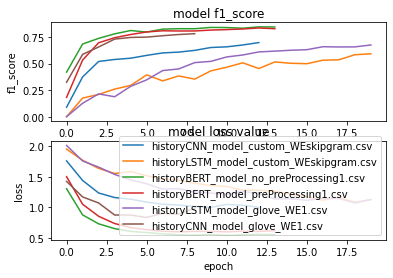

In [47]:
#single plot for f1 values, and loss values got from each model 
def compare_curves(): 
  plt.pyplot.subplot(211)
  plt.pyplot.title('model f1_score')
  plt.pyplot.ylabel('f1_score')
  plt.pyplot.xlabel('epoch')
  mod = []
  
  for dirpath, dirs, filenames in os.walk("./drive/MyDrive/history/"):
    for filename in filenames:
      mod.append(filename)
      hist_df = pd.read_csv(dirpath +"/"+filename, sep=',', delimiter=None )
      plt.pyplot.plot(hist_df['val_get_f1'])
  
  plt.pyplot.subplot(212)
  plt.pyplot.title('model loss value')
  plt.pyplot.ylabel('loss')
  plt.pyplot.xlabel('epoch')

  for dirpath, dirs, filenames in os.walk("./drive/MyDrive/history/"):
    for filename in filenames:
      mod.append(filename)
      hist_df = pd.read_csv(dirpath +"/"+filename, sep=',', delimiter=None )
      plt.pyplot.plot(hist_df['val_loss'])
  


  plt.pyplot.legend(mod, loc='upper rigth')
  plt.pyplot.show()

  
compare_curves()

In [48]:
hist_df = pd.read_csv("./drive/MyDrive/history/historyCNN_model_custom_WE1.csv", sep=',', delimiter=None )  
hist_df

FileNotFoundError: ignored